In [137]:
# import block
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
from astropy.visualization import hist
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D
from astropy.nddata import CCDData
phot_tutorial_dir = '/Users/levischult/Desktop/classes/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [138]:
# import convenience plotting functions downloaded from 
# here: https://github.com/mwcraig/ccd-reduction-and-photometry-guide
phot_tutorial_dir = '/Users/levischult/Desktop/classes/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [139]:
# for imaging, I like the photometry notebook plot defaults
# so use their custom style for larger fonts and figures
plt.style.use('/Users/levischult/Desktop/classes/ccd-reduction-and-photometry-guide/notebooks/guide.mplstyle')

# set a couple more default parameters for the plots below
rc('font', size=20)
rc('axes', grid=True)

In [140]:
def inv_median(x):
    return 1./np.median(x)

def inv_mean(x):
    return 1./np.mean(x)

def inv_mode(x):
    return 1./stats.mode(x,axis=None)[0][0]

In [161]:
data_dir = '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/imagedataset/'            # raw data directory
reduced_dir = '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/' # reduced working directory
#reduced_dir = '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/jessie_vflats/' # reduced working directory

In [162]:
imgs = ccdp.ImageFileCollection(reduced_dir, glob_include='*otz.fits')
#imgs = ccdp.ImageFileCollection(reduced_dir, glob_include='*otz.fits')

In [163]:
v_flat_imgs = imgs.files_filtered(imagetyp='SkyFlats', filter='V', include_path=True)
#v_flat_imgs = imgs_j.files_filtered(imagetyp='skyflat', filter='V', include_path=True)



In [164]:
v_flat_imgs

['/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a043_otz.fits',
 '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a044_otz.fits',
 '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a045_otz.fits',
 '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a046_otz.fits',
 '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a047_otz.fits',
 '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a048_otz.fits',
 '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a049_otz.fits']

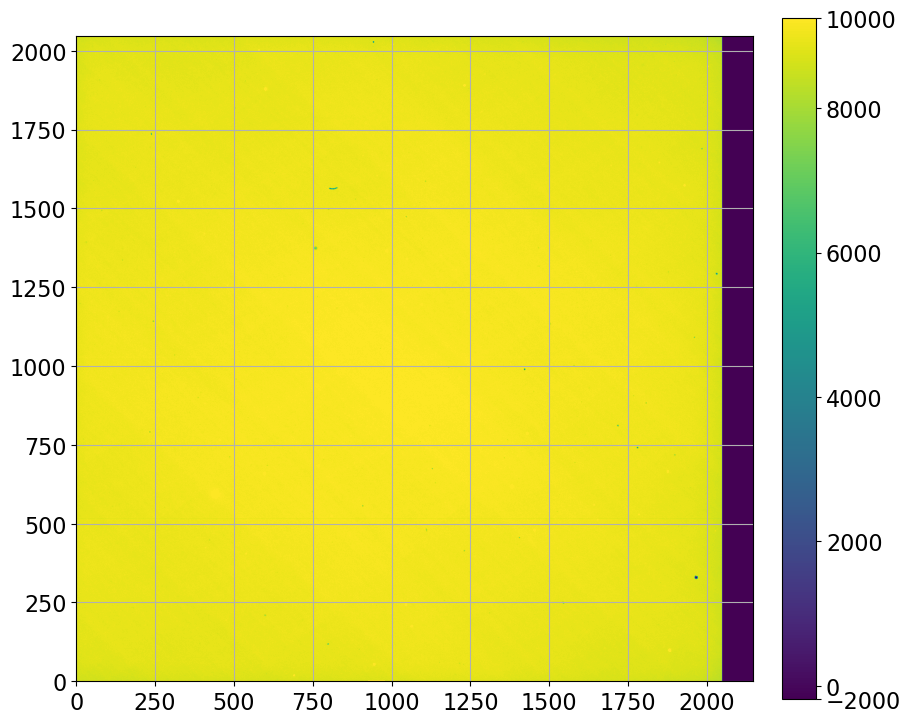

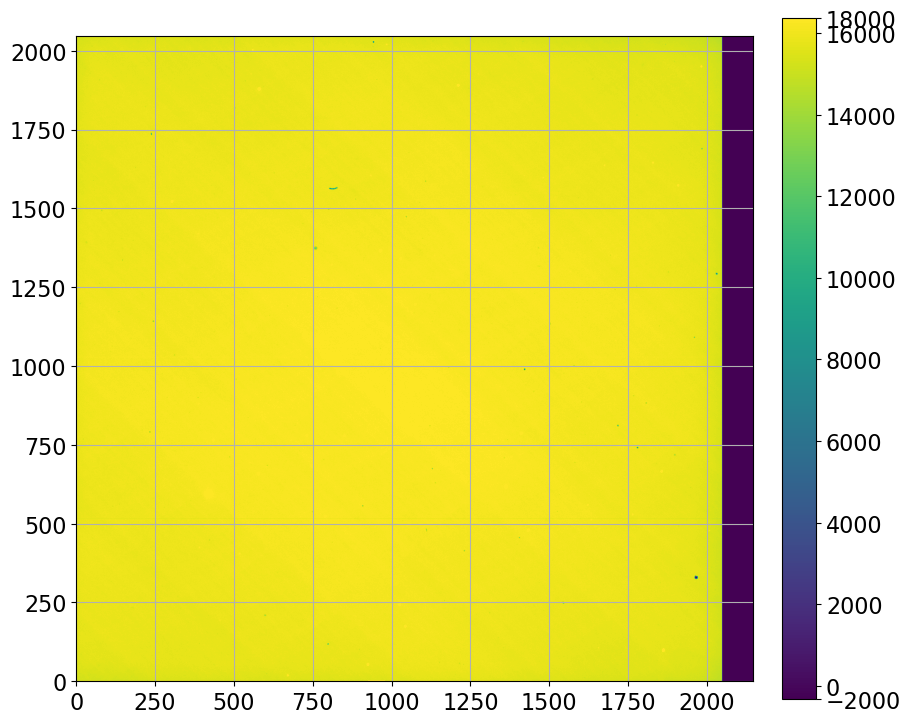

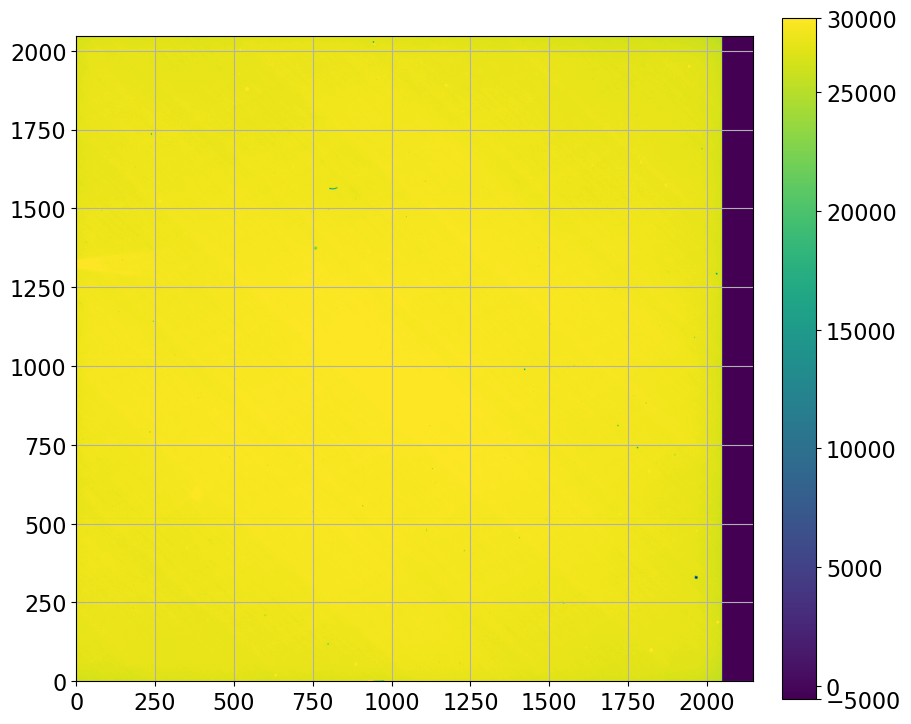

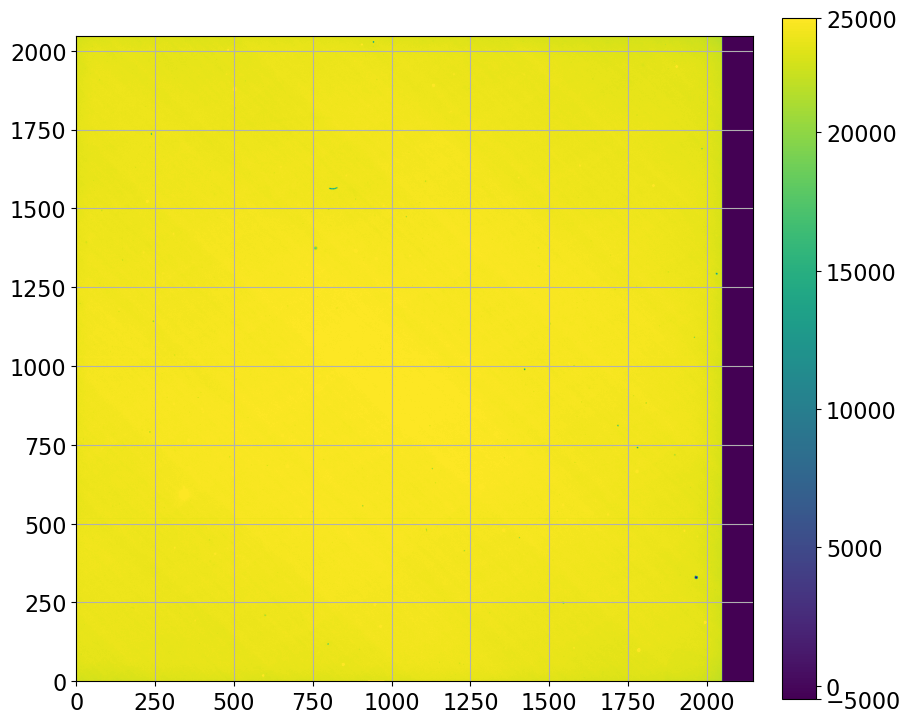

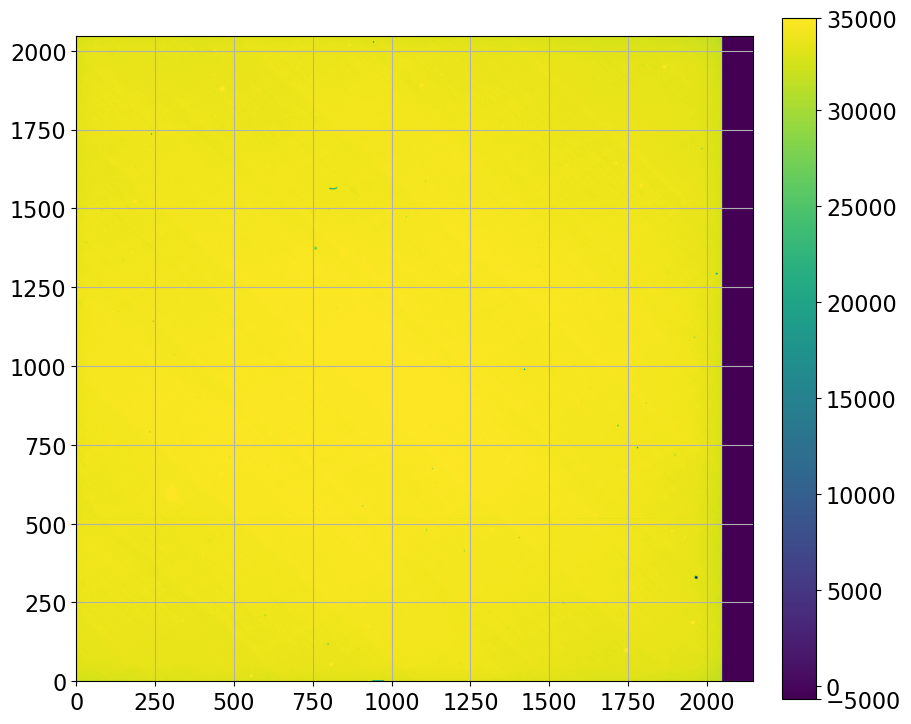

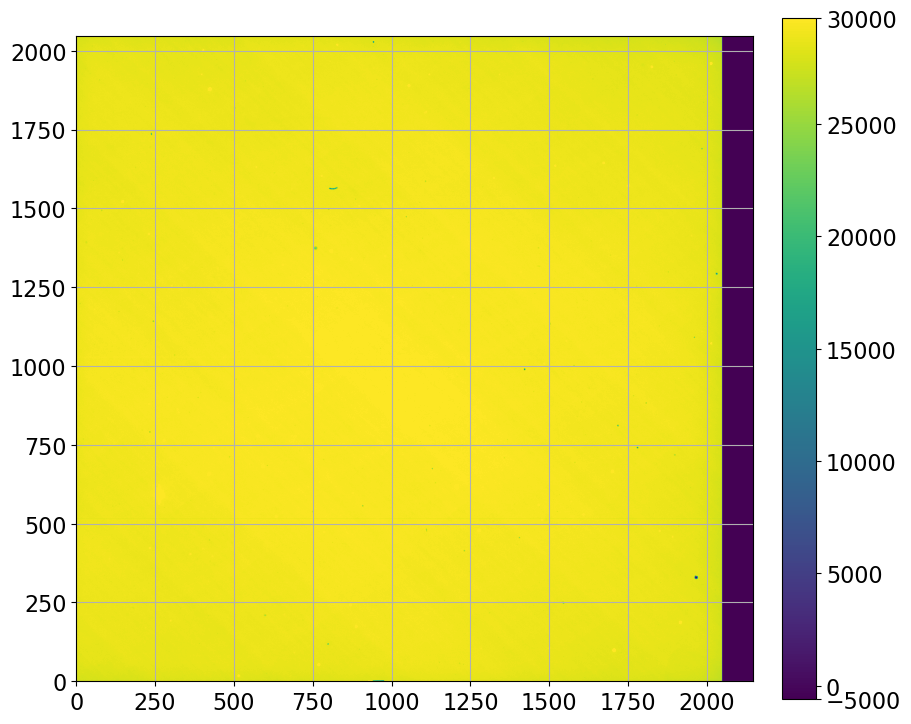

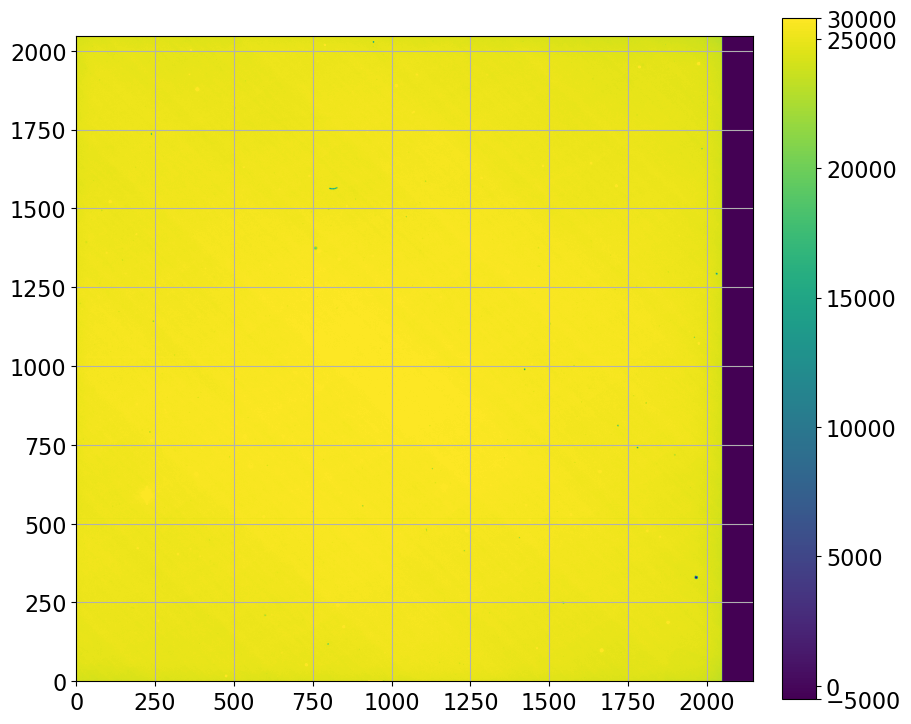

In [165]:
flat_medi = []
flat_mean = []

for idx, flatfile in enumerate(v_flat_imgs):
    hdu = fits.open(flatfile)
    img = hdu[0].data
    flat_medi.append(np.median(img))
    flat_mean.append(np.mean(img))
    show_image(img)


* serious artifacts - light leaks + dead pixels 

### plotting mean and median of flats to see variations

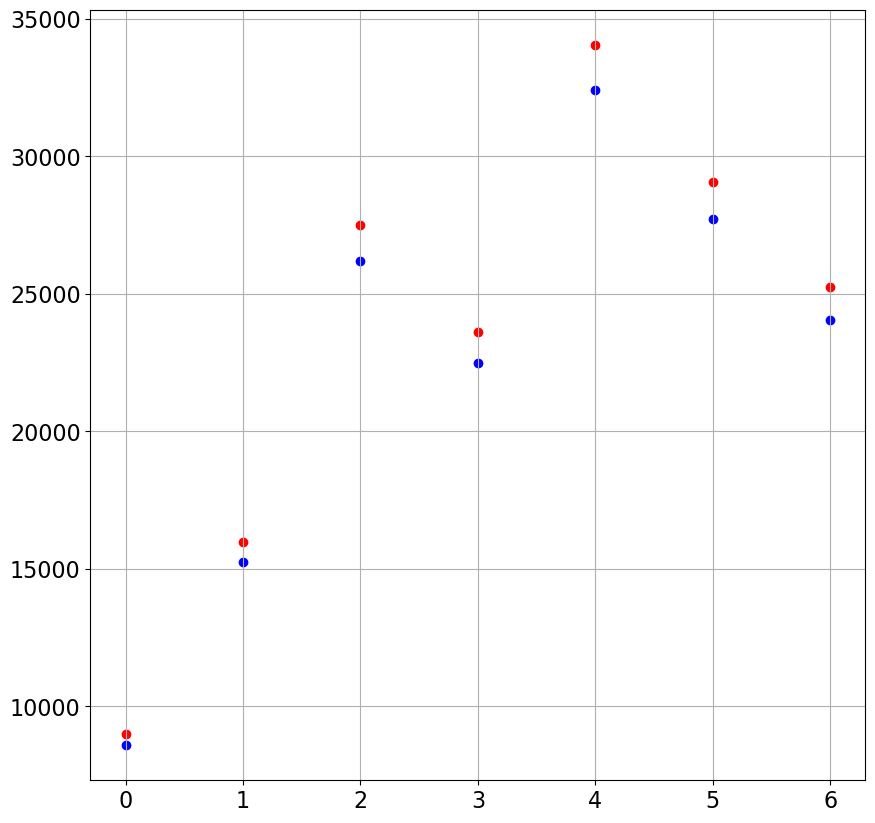

In [166]:
fig, ax = plt.subplots()
domain = range(len(v_flat_imgs))
plt.scatter(domain, flat_medi, c='r')
plt.scatter(domain, flat_mean, c='b')

* serious variations in the counts - likely due to the sky brightness changing
* will need to scale to a common level!

In [167]:
img.shape

(2048, 2145)

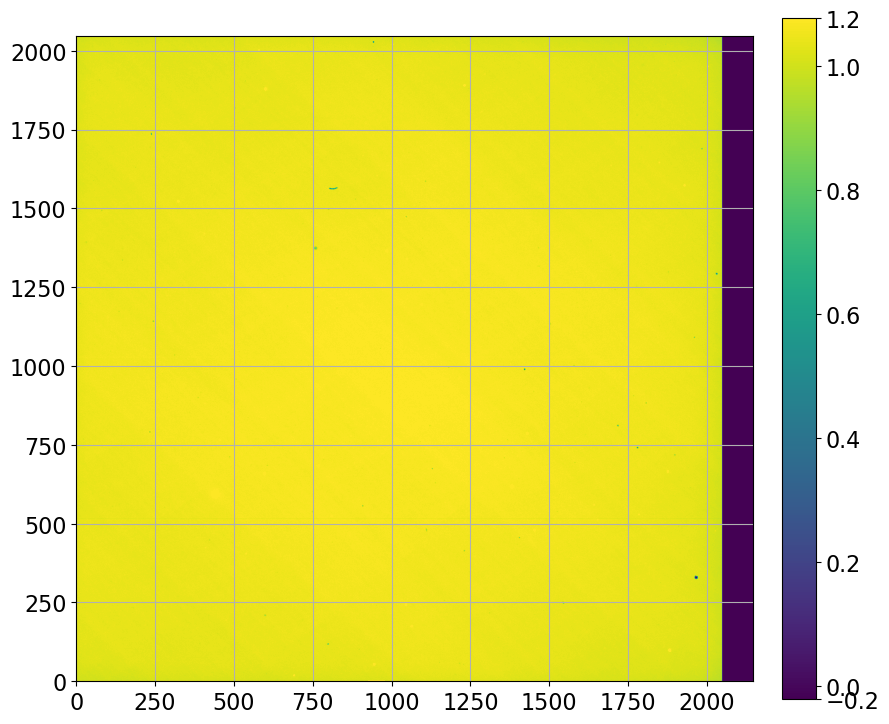

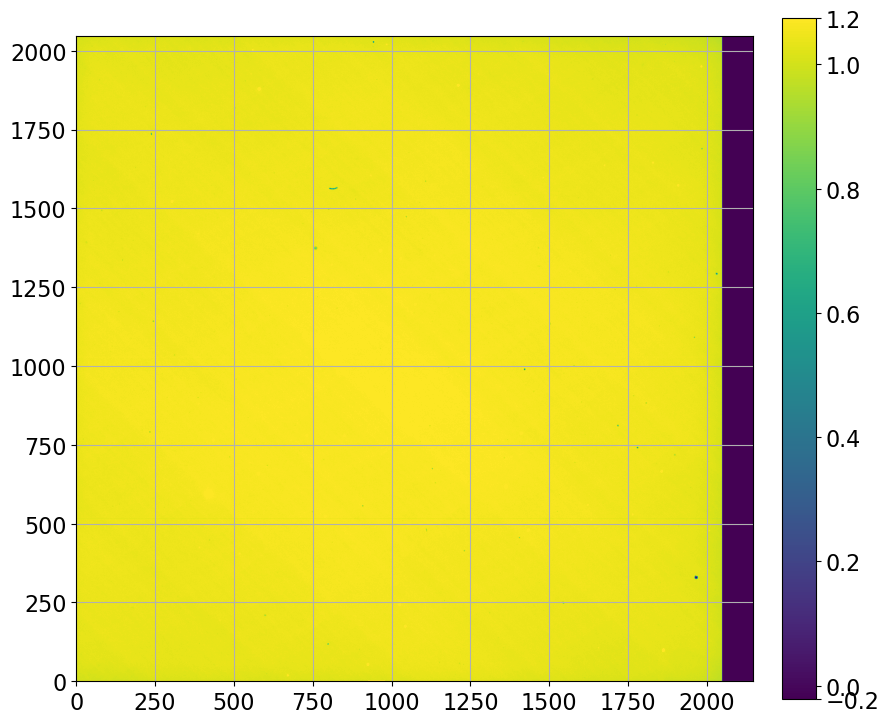

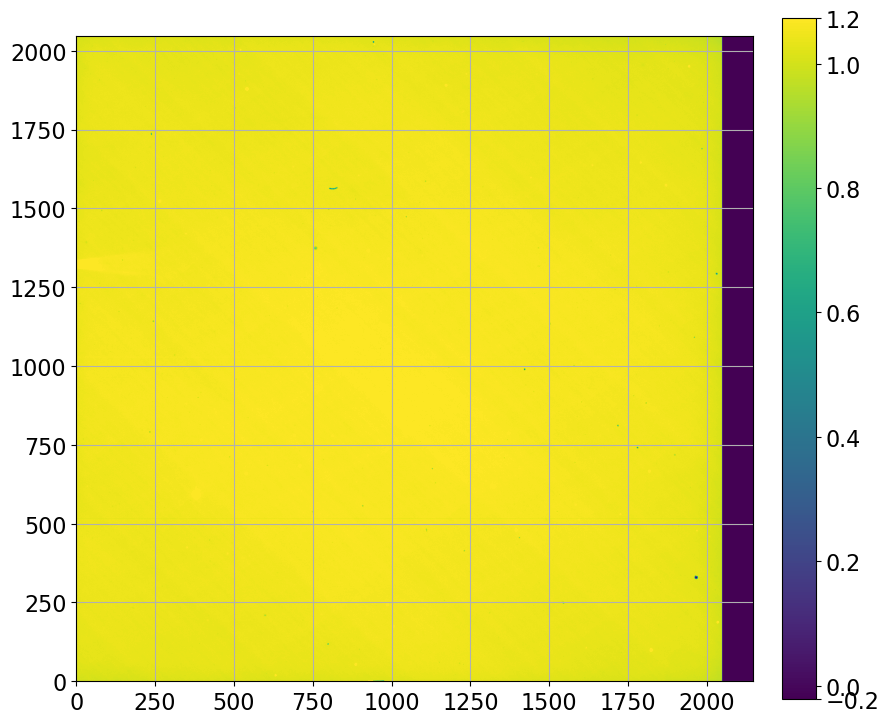

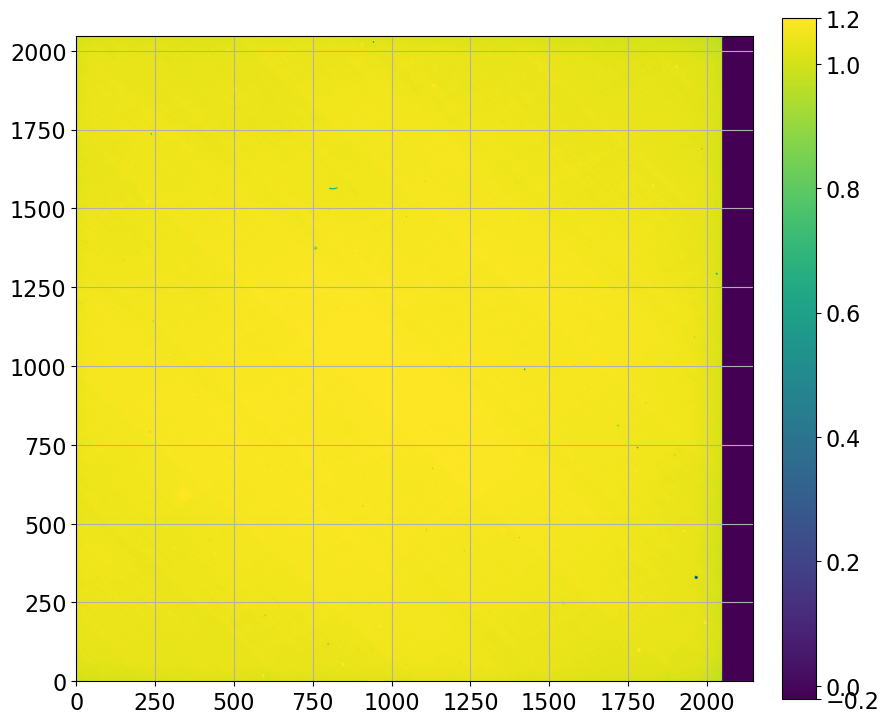

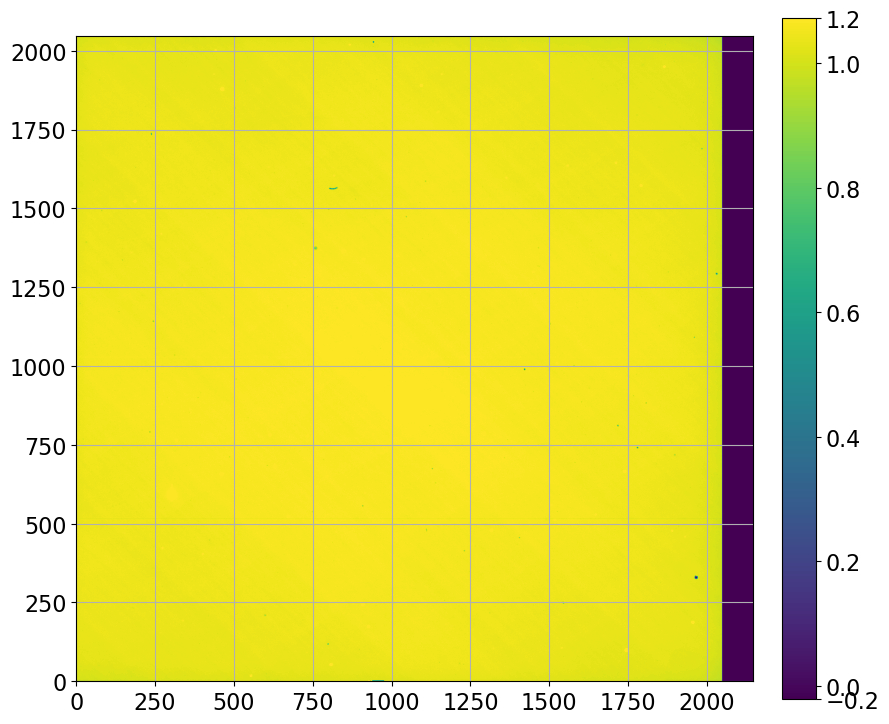

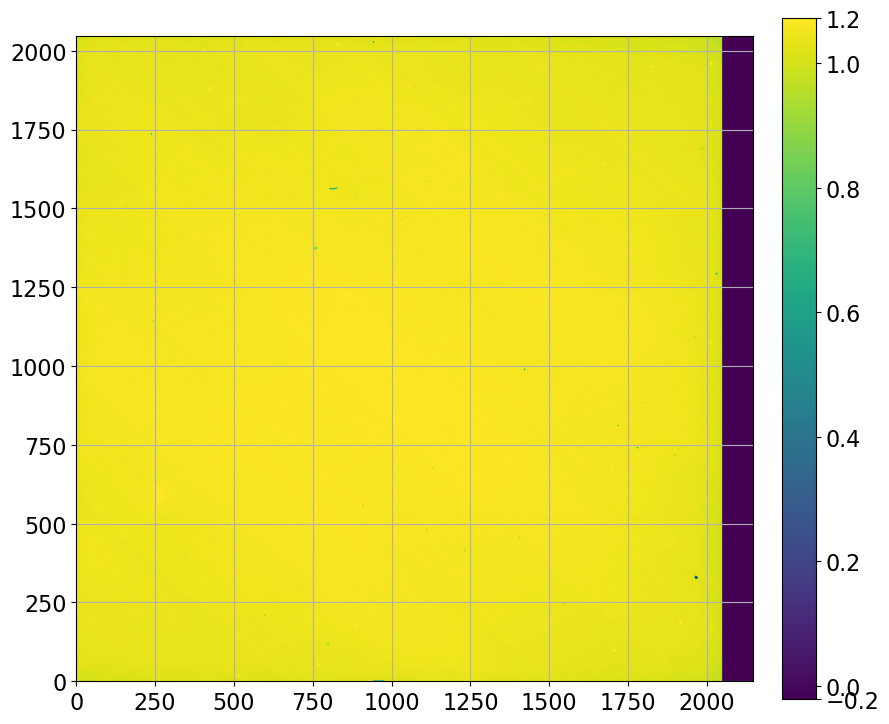

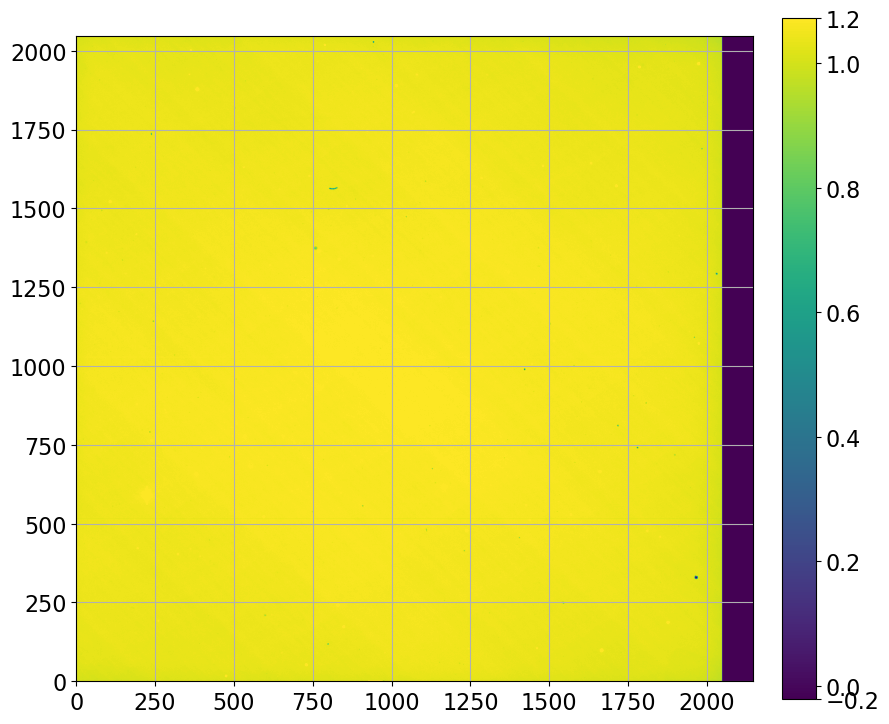

In [169]:
# normalizing the frames:
#norm_flats = np.zeros((7, 2048, 2048))
norm_flats = np.zeros((7, 2048, 2145))

for idx, flatfile in enumerate(v_flat_imgs):
    hdu = fits.open(flatfile)
    img = hdu[0].data
    norm_flats[idx] = img / np.mean(img)
    show_image(norm_flats[idx])

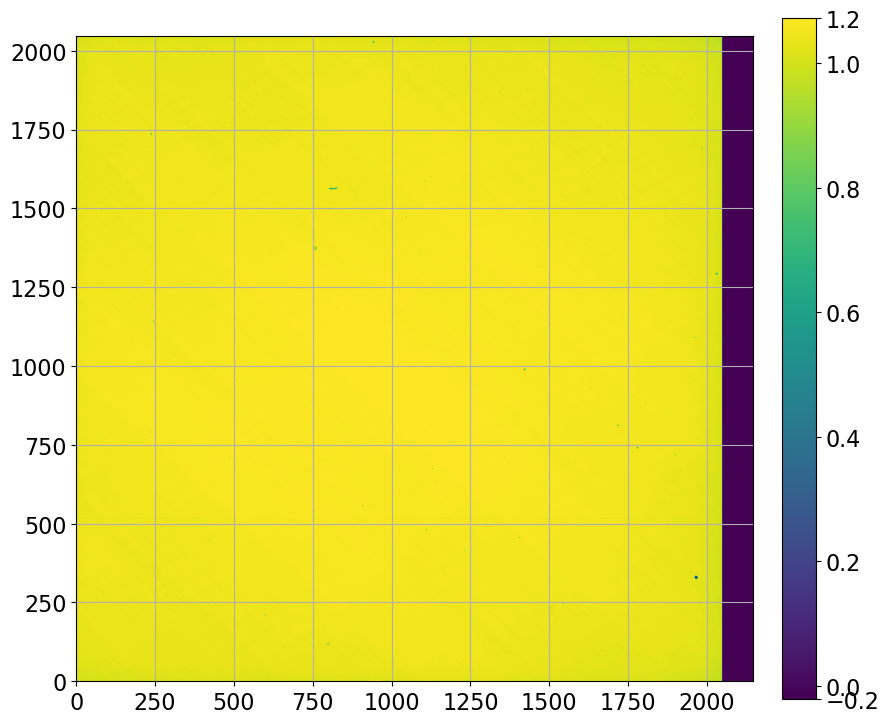

In [171]:
show_image(np.median(norm_flats, axis=0))

In [170]:
np.mean(norm_flats, axis=(1,2))

array([1., 1., 1., 1., 1., 1., 1.])

* flats all normalized now!

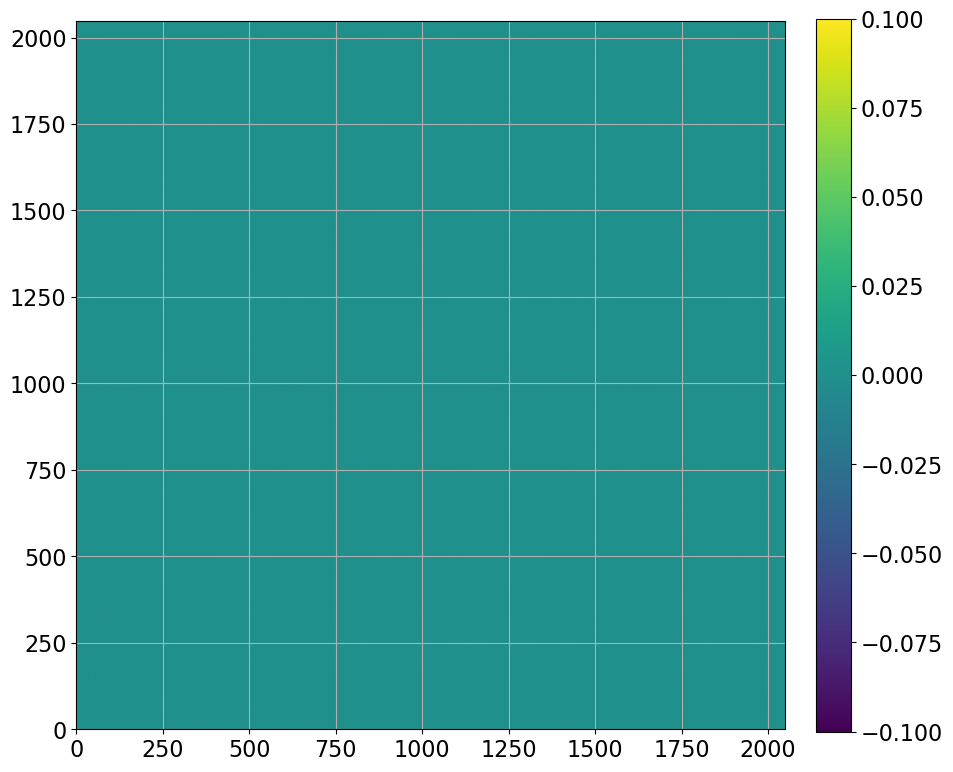

In [ ]:
mean_mescale_comb = np.mean(norm_flats, axis=0)
show_image(mean_mescale_comb)

* not a good idea to do a straight average combine after normalizing\
 (above). The lower count
flats from a dimmer sky get just as much weight as other higher count flats.\
also it results in star copies due to dithering.

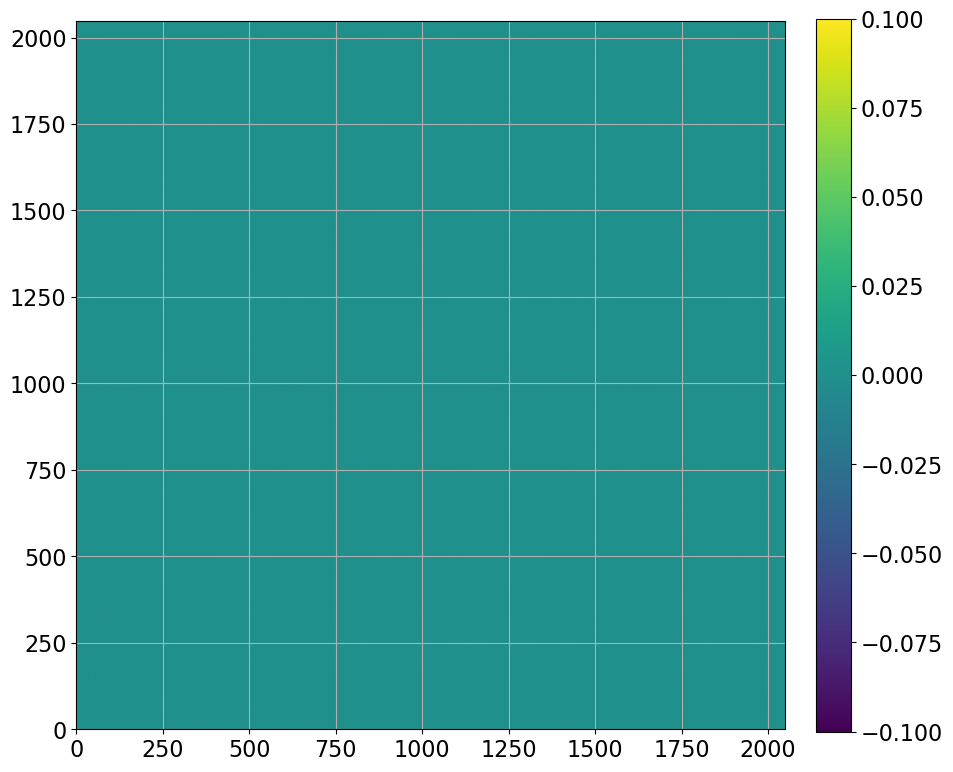

In [ ]:
medi_mescale_comb = np.median(norm_flats, axis=0)
show_image(medi_mescale_comb)

* median combine does remove the stars and some other artifacts, but again, the\
varied brightness is not taken into account - not an appropriate method of \
combining the flats

In [ ]:
# sigma clipped average
# now we will use the ccdp combine function which has some advanced features

# default sigma clipping is 3
mean_sigma_comb = ccdp.combine(v_flat_imgs, method='average', sigma_clip=True)
show_image(mean_sigma_comb)

IndexError: list index out of range

* looks about the same as the other average combined image... not great!\
dithered stars still present and the light leak is visible on the left side.\
Also very weighted to the flats with brighter sky!

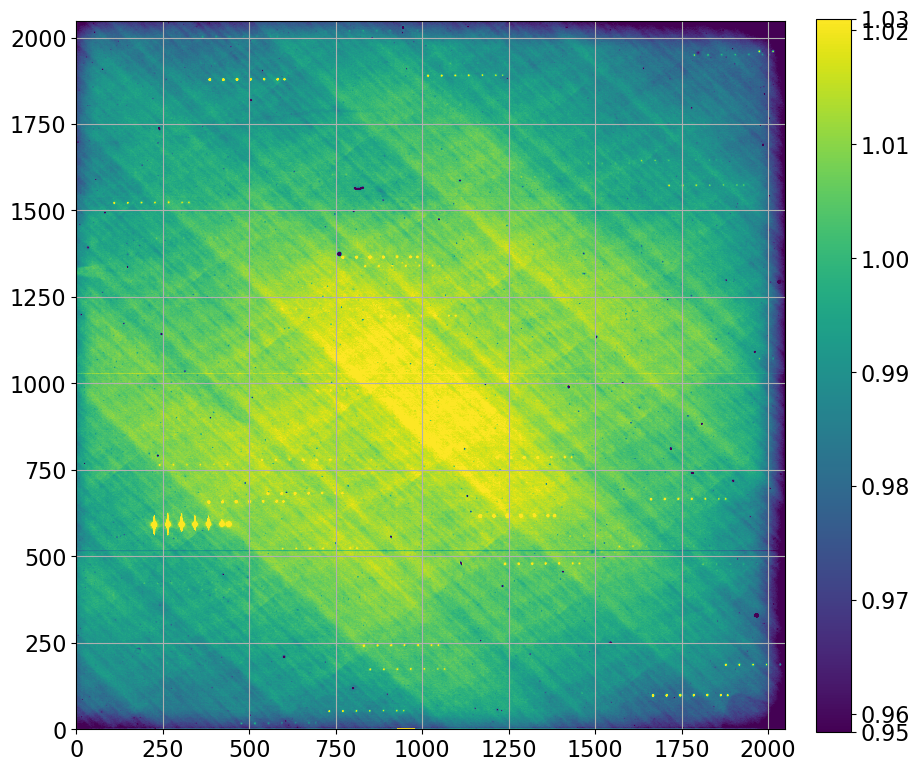

In [ ]:
# sigma clip avg with weighting according to median count!
mean_sigma_mdscale_comb = ccdp.combine(v_flat_imgs, method='average', sigma_clip=True,\
                                  scale=inv_median)
show_image(mean_sigma_mdscale_comb)

* Looks pretty similar to the other average BUT the power in each pixel is\
scaled relatively which is good!! Progress!

In [ ]:
# doing the straight mean/medi combinations no scaling
mean_comb = ccdp.combine(v_flat_imgs, method='average')
medi_comb = ccdp.combine(v_flat_imgs, method='median')


* lets compare rms!

In [ ]:
def calc_rms(array):
    return np.sqrt(np.mean(array**2))

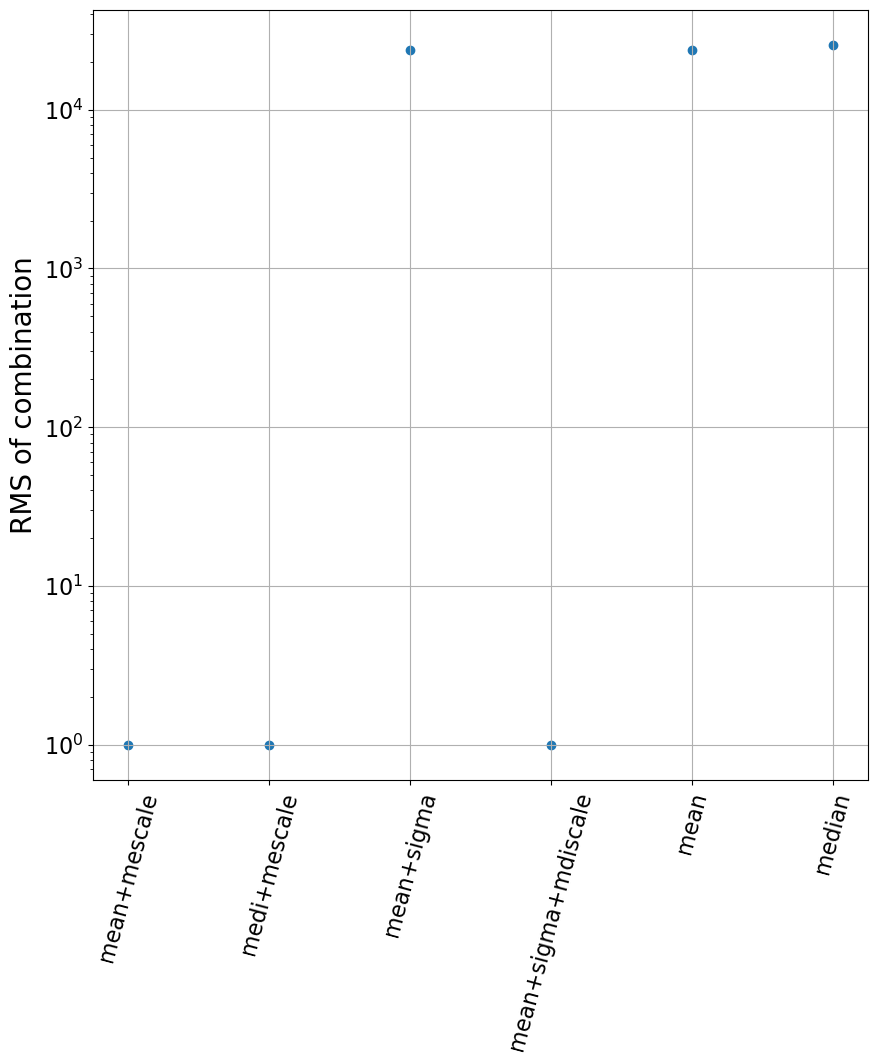

In [ ]:
combinations = [mean_mescale_comb, medi_mescale_comb, mean_sigma_comb, mean_sigma_mdscale_comb, mean_comb, medi_comb]
comb_rms = []
for comb in combinations:
    comb_rms.append(calc_rms(np.array(comb)))

comb_names = ['mean+mescale', 'medi+mescale', 'mean+sigma', 'mean+sigma+mdiscale', 'mean', 'median']
plt.scatter(comb_names, comb_rms)
plt.ylabel('RMS of combination')
plt.xticks(rotation=75)
plt.yscale('log')

In [ ]:
# trying my own combinations
# weighting by the the amount of the average counts compared to the total being
# combined...
flat_mean_pcent = flat_mean / np.array(flat_mean).sum()

In [ ]:
flat_weights = np.zeros((7, 2048, 2048))
for idx in range(7):
    flat_weights[idx].fill(flat_mean_pcent[idx])

In [ ]:
mean_mescale_mnwt_comb = ccdp.combine(v_flat_imgs, method='average', scale=inv_mean, weights=flat_weights, sigma_clipped=True)

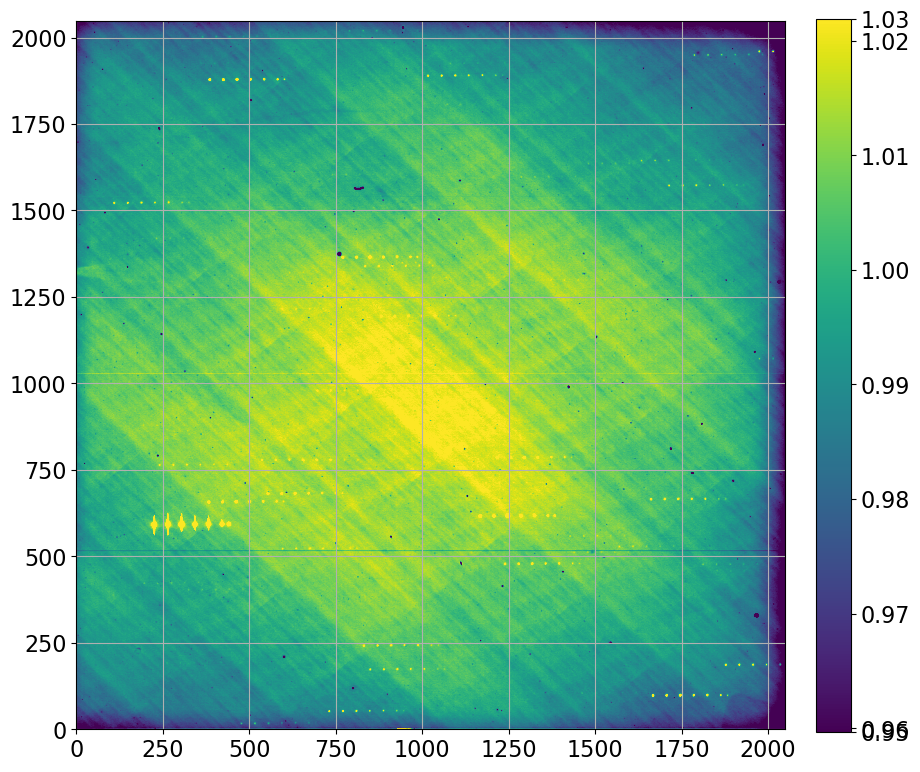

In [ ]:
show_image(mean_mescale_mnwt_comb)

* this weighted mean with each frame scaled by the mean and then also weighted \
by the percent of counts out of total still has dithered stars in it.
* will try a median combine of same thing

In [ ]:
medi_mescale_mnwt_comb = ccdp.combine(v_flat_imgs, method='median', scale=inv_mean, weights=flat_weights, sigma_clipped=True)

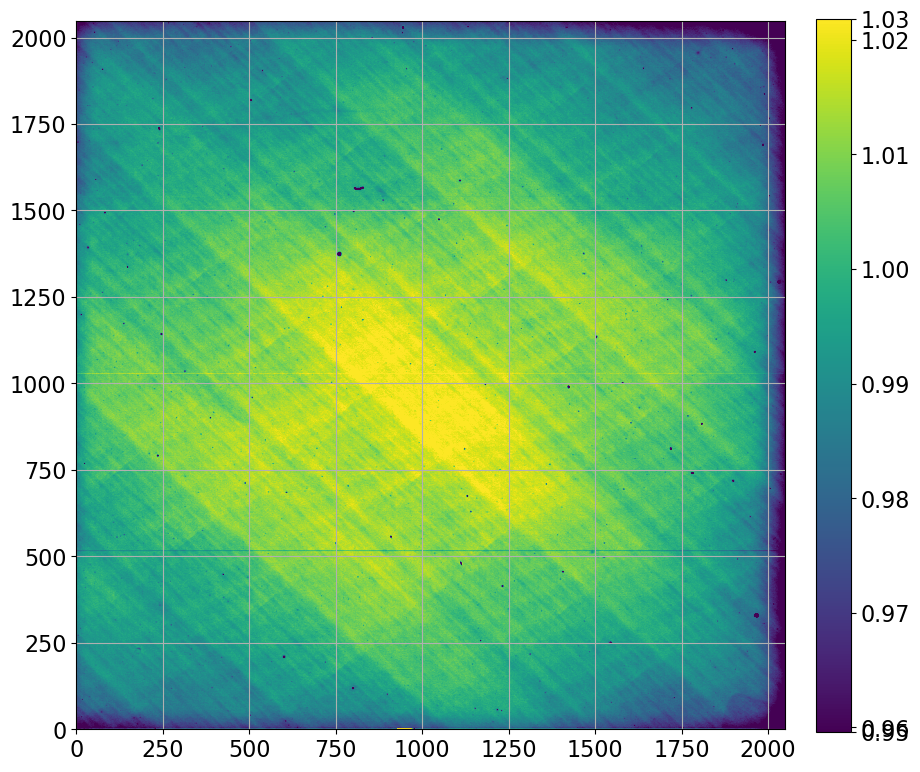

In [ ]:
show_image(medi_mescale_mnwt_comb)

In [ ]:
calc_rms(np.array(medi_mescale_mnwt_comb))

0.9999694360973599

* This looks pretty good!! No stars or light leak and the flats are weighted by\
how bright the sky was!

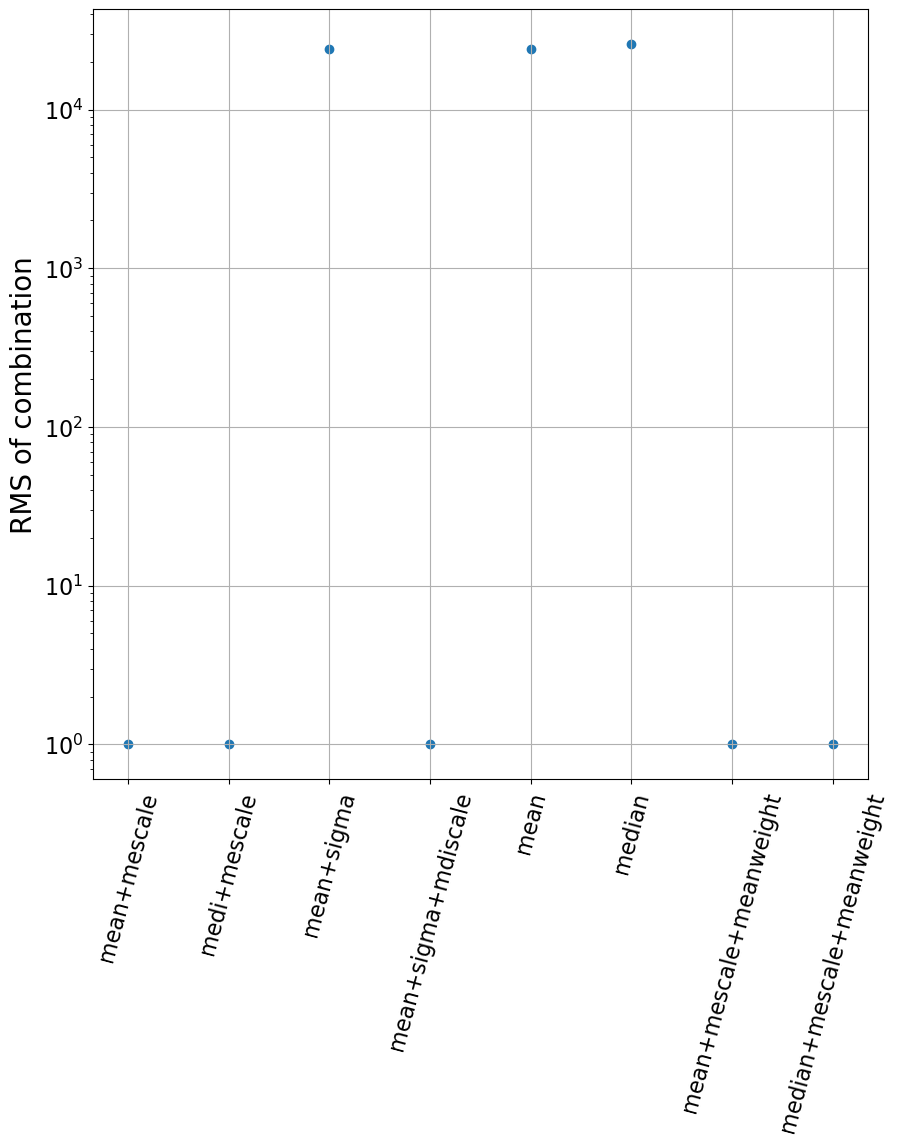

In [ ]:
combinations = [mean_mescale_comb, medi_mescale_comb, mean_sigma_comb, mean_sigma_mdscale_comb, mean_comb, medi_comb, mean_mescale_mnwt_comb, medi_mescale_mnwt_comb]
comb_rms = []
for comb in combinations:
    comb_rms.append(calc_rms(np.array(comb)))

comb_names = ['mean+mescale', 'medi+mescale', 'mean+sigma', 'mean+sigma+mdiscale', 'mean', 'median', 'mean+mescale+meanweight', 'median+mescale+meanweight']
plt.scatter(comb_names, comb_rms)
plt.ylabel('RMS of combination')
plt.xticks(rotation=75)
plt.yscale('log')

# 2

In [ ]:
halpha_flat_imgs = imgs.files_filtered(imagetyp='skyflat', filter='Halpha', include_path=True)


In [ ]:
halpha_msflat = ccdp.combine(halpha_flat_imgs, method='median', scale=inv_mean, weights=flat_weights, sigma_clipped=True)

IndexError: list index out of range

# 3

In [ ]:
np.mean(np.array(medi_mescale_mnwt_comb))

0.9998635401423834

In [ ]:
v_msflat_norm = np.array(medi_mescale_mnwt_comb) / np.mean(np.array(medi_mescale_mnwt_comb))

In [ ]:
np.mean(v_msflat_norm)

1.0

In [ ]:
halpha_msflat_norm = np.array(halpha_msflat) / np.mean(np.array(halpha_msflat))

NameError: name 'halpha_msflat' is not defined

# 4

In [ ]:
scienceimgs = '''science filtered objects with ccdp.flat_correct'''